#  Analyzing and Predicting Player Count Trends in Online Games

## Part 4: Model Selection, Recommendations, and Conclusions

This section of our investigation serves to provide a definite answer to which constructed model serves our purposes best. Then, we will conclude our investigation with recommendations based upon our exploratory data analysis and modelling work. Finally, we will suggest how this investigation could be improved upon for future work. 


In [1]:
!pip install -U fsds

import math
import pickle
from scipy.stats import boxcox as bc
import scipy.stats
import itertools
import statistics as stats
from fsds.imports import * 
from datetime import datetime
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

fsds v0.2.30 loaded.  Read the docs: https://fs-ds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


[i] Pandas .iplot() method activated.


In [2]:
# we import our testing data

csgo = pd.read_csv('data/Test/csgo_test.csv')
dota = pd.read_csv('data/Test/dota_test.csv')
rl = pd.read_csv('data/Test/rl_test.csv')
tf = pd.read_csv('data/Test/tf_test.csv')

ls = [csgo, dota, rl, tf]

# again, our time column needs to be updated to 'datetime'

def to_datetime(df, col, form):
    for i in range(len(df)):
        df[col][i] = str((df[col][i])).replace('-','')
    df[col] = pd.to_datetime(df[col], format = form)
    return df

ls = list(map(lambda df: to_datetime(df, 'time', '%Y%m%d'), ls))
ls = list(map(lambda df: df.drop(columns = ['time.1']), ls))
ls = list(map(lambda df: df.set_index('time'), ls))

testing_ls = ls

# and our models

csgo_model = pickle.load(open("models/csgo_model.pkl", "rb"))
dota_model = pickle.load(open("models/dota_model.pkl", "rb"))
rl_model = pickle.load(open("models/rl_model.pkl", "rb"))
tf_model = pickle.load(open("models/tf_model.pkl", "rb"))
mean_model = pickle.load(open("models/mean_model.pkl", "rb"))
control_model = pickle.load(open("models/tf_model.pkl", 'rb'))

model_ls = [csgo_model, dota_model, rl_model, tf_model]



## Model Selection

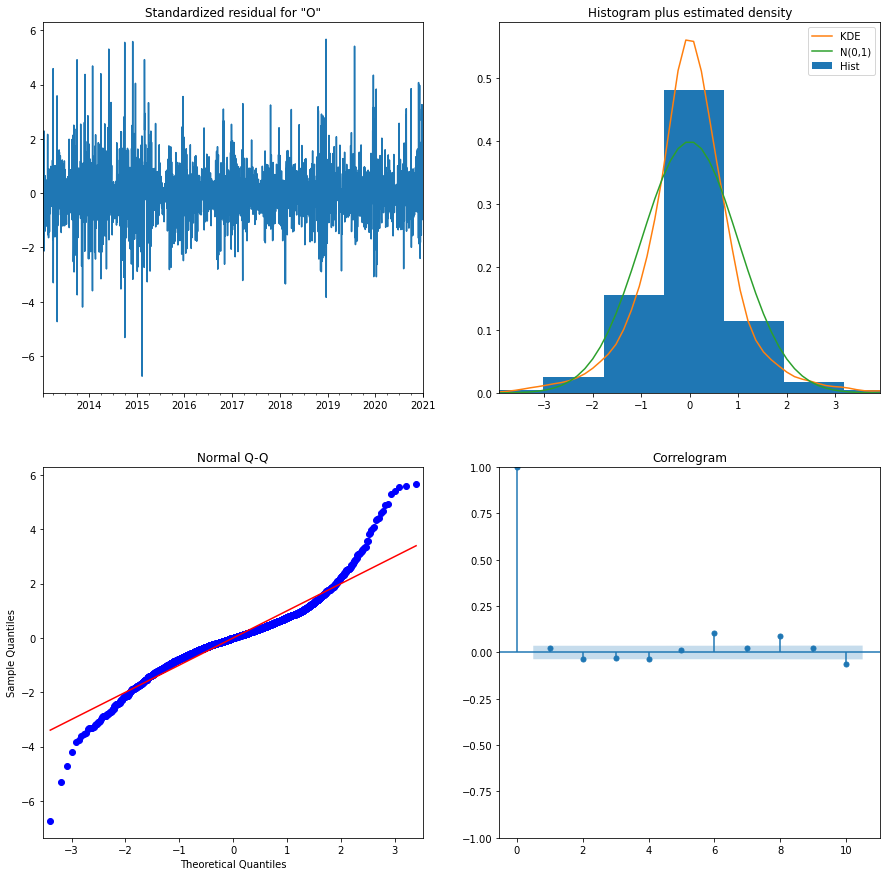

In [3]:
# we compare our control_model (tf_model) to our mean_model

control_output = control_model.fit()
control_output.plot_diagnostics(figsize = (15,15))
plt.show()

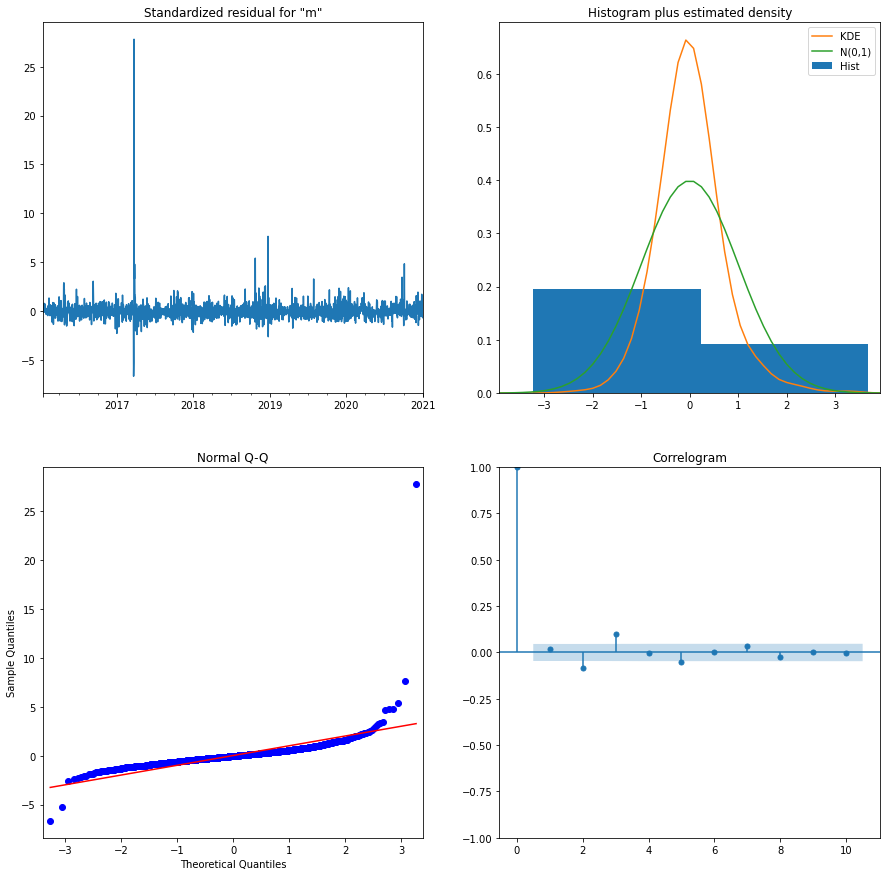

In [4]:
mean_output = mean_model.fit()
mean_output.plot_diagnostics(figsize = (15,15))
plt.show()

##### Comparing our Control Model V Mean Model

We will be continuing with our amalgamized model, or the Mean Model. This is due to the above visualizations, which show that our mean model follows the modelling assumptions closer than our control model. 

### Predicting Number of Players
We will be comparing how the mean model compares against each game's basic model constructed off it's own data. This will accomplish two things: first, we will gain two values for number of players and be able to select a model that best predicts this value for the given game. Second, this will tell us whether a model is made more or less effective by incorporating data from multiple games rather than modelling off of one games own data. 

In [5]:
# we will predict the number of players for each game at the same time: 2020-12-12 (randomly selected Saturday) 
# through 2 dynamic forecasts:
# first forecast start = 2020-12-01, for short run predictive power
# second forecast start = 2020-01-01, for long run predictive power
# declare model winner for long run and short run

In [6]:
# first address differences, then unlog data

def differenced_logged_data_to_players(forecast, start_time, testing_df):
    logged_player_count = (testing_df['players_logged'][start_time])
    forecast_df = pd.DataFrame(testing_df['players'][start_time:])
    player_count = []
    for diff in (forecast):
        logged_player_count += diff
        players = math.exp(logged_player_count)
        player_count.append(players)
    forecast_df['players'] = player_count
    return forecast_df
        
    
    

In [7]:
def percent_change_data_to_players(forecast, start_time, testing_df):
    player_count = testing_df['players'][start_time]
    forecast_df = pd.DataFrame(testing_df['players'][start_time:])
    forecast_player_count = []
    for chg in forecast:
        player_count = player_count + (player_count*chg)
        forecast_player_count.append(player_count)
    forecast_df['players'] = forecast_player_count
    return forecast_df
        

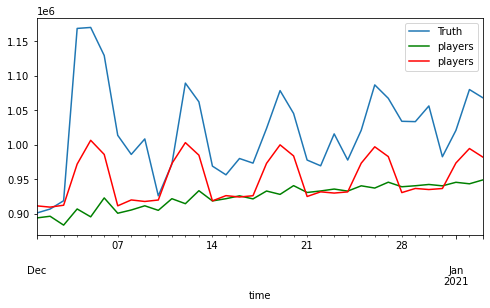

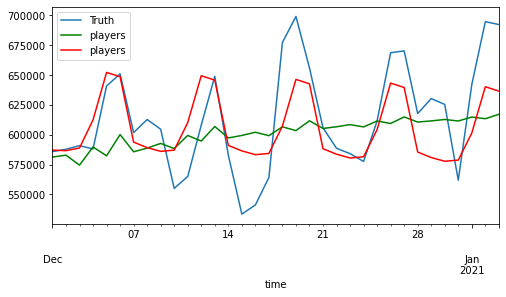

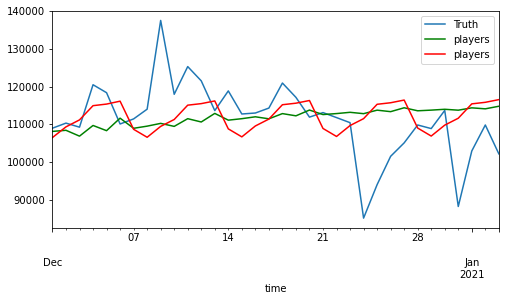

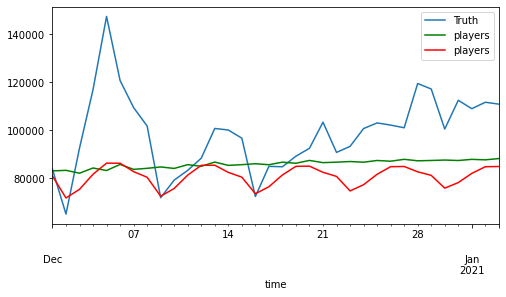

In [8]:
# SHORT RUN FORECASTING

# we visualize the predictions for each of our games, their own model vs our mean_model

mean_model_mse_vals = []
game_model_mse_vals = []

for i in range(len(testing_ls)):
    ax = plt.subplots(figsize = (8, 4))
    
    ax = ls[i]["2020-12-01":]['players'].plot(label = 'Truth')
    
    mean_pred = mean_output.get_prediction(start = pd.to_datetime("2020-12-01"), dynamic = True, full_results = True)
    mean_forecast = mean_pred.predicted_mean
    mean_forecast_transformed = percent_change_data_to_players(mean_forecast,"2020-12-01", testing_df = ls[i])
    
    game_output = model_ls[i].fit()
    game_pred = game_output.get_prediction(start = pd.to_datetime("2020-12-01"), dynamic = True, full_results = True)
    game_forecast = game_pred.predicted_mean
    game_forecast_transformed = differenced_logged_data_to_players(game_forecast,"2020-12-01", ls[i])
    
    mean_forecast_transformed.plot(ax = ax, color = 'green', label = 'Mean Model Forecast')
    game_forecast_transformed.plot(ax = ax, color = 'red', label = 'Game Model Forecast')
    plt.legend()
    plt.show()
    
    
    # also calculate mse while we have our forecasts established
    truth = ls[i]["2020-12-01":]['players']
    mean_model_mse = ((mean_forecast_transformed['players'] - truth)**2).mean()
    game_model_mse = ((game_forecast_transformed['players'] - truth)**2).mean()
    
    mean_model_mse_vals.append(mean_model_mse)
    game_model_mse_vals.append(game_model_mse)

In [9]:
mse_df = pd.DataFrame()
mse_df['MEAN_MODEL_MSE'] = mean_model_mse_vals
mse_df['GAME_MODEL_MSE'] = game_model_mse_vals
mse_df

,MEAN_MODEL_MSE,GAME_MODEL_MSE
0,1.301710e+10,6.708728e+09
1,1.808460e+09,1.034349e+09
2,1.156107e+08,1.125343e+08
3,4.166135e+08,5.176964e+08


#### Short Run Forecasting Conclusions

As we can see, our mean model did not perform better than our game models in all games but Team Fortress 2. Furthermore, we see that our mean_model does not handle sharp increases or decreases in player counts well, but the trend in player counts is more reliable in our mean model than in a game's model. 

To conclude, a model built on multiple games does not perform better on a given game compared to a model built on that game's own data. Thus, if a game's data is available, a model should be constructed on that. The only application of our mean model is on games whose data is not available to us. 

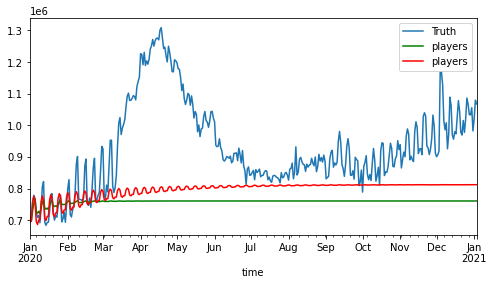

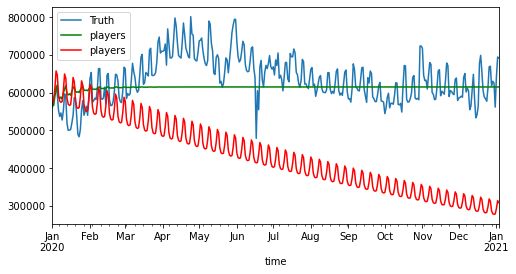

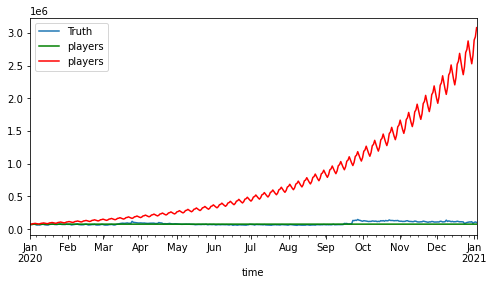

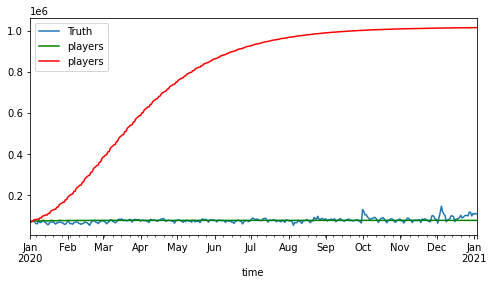

In [10]:
# LONG RUN FORECASTING

# we visualize the predictions for each of our games, their own model vs our mean_model

mean_model_mse_vals = []
game_model_mse_vals = []

for i in range(len(testing_ls)):
    ax = plt.subplots(figsize = (8, 4))
    
    ax = ls[i]["2020-01-01":]['players'].plot(label = 'Truth')
    
    mean_pred = mean_output.get_prediction(start = pd.to_datetime("2020-01-01"), dynamic = True, full_results = True)
    mean_forecast = mean_pred.predicted_mean
    mean_forecast_transformed = percent_change_data_to_players(mean_forecast,"2020-01-01", testing_df = ls[i])
    
    game_output = model_ls[i].fit()
    game_pred = game_output.get_prediction(start = pd.to_datetime("2020-01-01"), dynamic = True, full_results = True)
    game_forecast = game_pred.predicted_mean
    game_forecast_transformed = differenced_logged_data_to_players(game_forecast,"2020-01-01", ls[i])
    
    mean_forecast_transformed.plot(ax = ax, color = 'green', label = 'Mean Model Forecast')
    game_forecast_transformed.plot(ax = ax, color = 'red', label = 'Game Model Forecast')
    plt.legend()
    plt.show()
    
    
    # also calculate mse while we have our forecasts established
    truth = ls[i]["2020-01-01":]['players']
    mean_model_mse = ((mean_forecast_transformed['players'] - truth)**2).mean()
    game_model_mse = ((game_forecast_transformed['players'] - truth)**2).mean()
    
    mean_model_mse_vals.append(mean_model_mse)
    game_model_mse_vals.append(game_model_mse)

In [11]:
mse_df = pd.DataFrame()
mse_df['MEAN_MODEL_MSE'] = mean_model_mse_vals
mse_df['GAME_MODEL_MSE'] = game_model_mse_vals
mse_df

,MEAN_MODEL_MSE,GAME_MODEL_MSE
0,4.723072e+10,3.439173e+10
1,3.909412e+09,5.330447e+10
2,6.094548e+08,1.005649e+12
3,1.296538e+08,5.656084e+11


#### Long Run Forecasting Conclusions

It appears that for all games other than CS:GO, game models diverge in a dynamic forecast. Our mean models, however, perform much better, and converge. This convergence will result in our mean_model being more accurate than game models.

This may suggest that our mean model, while not successful at predicting short run fluctuations, may be successfull in predicting long run trends. 

### Recommendations

We have prepared many recommendations for game production businesses based upon our findings. We will begin with findings from our EDA section.

1. As a player base increases, so too does the volatility of the number of players. This means that the maximum amount of players will increase exponentially as average number of players increases. Accounting for this would suggest that a company should invest in server space (capital) at a rate faster than the growth of its player base. 

2. Through our investigation of events, we found that an ongoing event did not have a significant impact on number of players, but did have a significant impact on number of twitch viewers. If a company is trying to increase social media presence, then events are an effective way of increasing viewership.

And the recommendations from our modelling section:

1. When predicting long-term player trends, a model built from multiple games will perform better than a model built from that one games data. Conversely, when predicting short-term trends, including data from other games hinders predictive power. 



### Further Work

One major way in which this investigation could be improved is in data collection frequency, specifically if our data was collected at least hourly, instead of daily. This would allow us to discern smaller trends in player counts, giving better context to how these figures move throughout the day, instead of throughout larger periods as we have investigated here. 

Attempting to include events as an exogenous variable in our modelling hindered accuracy, though the relationship between events and player counts was shown to exist in our EDA section, however small it may be. This suggests that our events, as we defined them, did not explain enough to merit being included in our final modelling. We should therefore work on collecting event data in a different way, or redefine 'event' for use in our investigation. 

Finally, this process could be completed for games of a particular company. It may be possible that building models from one companies portfolio of games may lead to a more accurate model than our averaged model constructed here. 